In [ ]:
import numpy as np
import pandas as pd
import os 
import torch

In [1]:
import pickle

In [2]:
import collections, os, io
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset
import random
import pickle
import utils_disco
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import ipdb 
st = ipdb.set_trace

In [3]:
print(os.listdir('/home/mprabhud/dataset/clevr_veggies/npys'))

dataset_path = '/home/mprabhud/dataset/clevr_veggies/npys'

['sp', 'shapenet_temp', 'be_lv.txt', 'bb_lt.txt', 'bd_lt.txt', 'bc_lv.txt', 'shapenet_13v.txt', 'bd_l', 'cylinder_13v.txt', 'ba_lv.txt', 'shapenet_tempt.txt', 'bb_lv.txt', 'be_lt.txt', 'cylinder_13', 'ba_l', '.ipynb_checkpoints', 'ba_lt.txt', 'shapenet_tempv.txt', 'cylinder_13t.txt', 'shapenet_13t.txt', 'bc_l', 'bc_lt.txt', 'bd_lv.txt', 'bb_l', 'shapenet_13']


In [4]:
data = pickle.load(open('/home/mprabhud/dataset/clevr_veggies/npys/bc_l/CLEVR_new_000088.p', "rb"))

In [5]:
data.keys()

dict_keys(['tree_seq_filename', 'pix_T_cams_raw', 'origin_T_camXs_raw', 'rgb_camXs_raw', 'camR_T_origin_raw', 'xyz_camXs_raw'])

In [6]:
data['rgb_camXs_raw'].shape, data['origin_T_camXs_raw'].shape

((40, 256, 256, 4), (40, 4, 4))

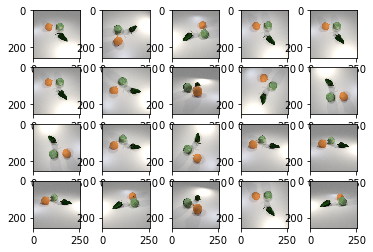

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(4,5)
for row in range(4):
    for col in range(5):
        axarr[row,col].imshow(data['rgb_camXs_raw'][4*row + col,:,:,:3])

In [8]:
data['tree_seq_filename']

'CLEVR_MULTIPLE_256_NO_SHEAR_LOW_ELEVATION_3/trees_updated/train/CLEVR_new_000088.tree'

In [9]:
hyp_N = 10

In [10]:
def bbox_rearrange(tree,boxes= [],classes={},all_classes=[]):
	for i in range(0, tree.num_children):
		updated_tree,boxes,classes,all_classes = bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
		tree.children[i] = updated_tree     
	if tree.function == "describe":
		xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
		box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
		tree.bbox_origin = box
		boxes.append(box)
		classes["shape"] = tree.word
		all_classes.append(classes)
		classes = {}
	if tree.function == "combine":
		if "large" in tree.word or "small" in tree.word:
			classes["size"] = tree.word
		elif "metal" in tree.word or "rubber" in tree.word:
			classes["material"] = tree.word
		else:
			classes["color"] = tree.word
	return tree,boxes,classes,all_classes

In [11]:
tree = pickle.load(open(os.path.join("/home/mprabhud/dataset/clevr_veggies",data['tree_seq_filename']),"rb"))
tree,boxes,_,_ = bbox_rearrange(tree,boxes=[],classes={},all_classes=[])

In [12]:
boxes = np.stack(boxes)

In [13]:
def collate_boxes(data):
    query_image, num_boxes_q, boxes_q, query_viewpoint, key_image, num_boxes_k, boxes_k, key_viewpoint, scene_num, key_img_view, pix_T_cams_raw, camR_T_origin_raw, origin_T_camXs_raw = zip(*data)
    batch_size = len(num_boxes_q)
    
#     print(torch.stack(list(query_image)))
    query_image = torch.stack(list(query_image))
    key_image = torch.stack(list(key_image))
    
 
    num_boxes_q = torch.tensor(list(num_boxes_q))
    num_boxes_k = torch.tensor(list(num_boxes_k))
    
    boxes_q = list(boxes_q)
    boxes_k = list(boxes_k)
 
    object_boxes_q = torch.cat(boxes_q, dim=0)
    object_boxes_k = torch.cat(boxes_k, dim=0)
    
    query_viewpoint = torch.stack(list(query_viewpoint))
    key_viewpoint = torch.stack(list(key_viewpoint))
    
    scene_num = (list(scene_num))
    key_img_view = (list(key_img_view))
    pix_T_cams_raw = torch.stack(list(pix_T_cams_raw), dim=0)
    camR_T_origin_raw = torch.stack(list(camR_T_origin_raw), axis=0)
    origin_T_camXs_raw = torch.stack(list(origin_T_camXs_raw), axis=0)
    
    
    metadata = {"scene_number":scene_num, "key_image_index":key_img_view, "pix_T_cams_raw":torch.tensor(pix_T_cams_raw).cuda(), "camR_T_origin_raw":torch.tensor(camR_T_origin_raw).cuda(), "origin_T_camXs_raw":torch.tensor(origin_T_camXs_raw).cuda()}
    feed_dict_q = {"images":query_image, "objects":num_boxes_q, "objects_boxes":torch.tensor(object_boxes_q).cuda(), "view":query_viewpoint}
    feed_dict_k = {"images":key_image, "objects":num_boxes_k, "objects_boxes":torch.tensor(object_boxes_k).cuda(), "view":key_viewpoint}
    
    
    return feed_dict_q, feed_dict_k, metadata

In [14]:
class GQNDataset_pdisco(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None, few_shot=False):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target_res = 256
        self.N = 10
        self.few_shot = few_shot
        self.views = 40

        if root_dir.endswith("txt"):
            data  = []

            with open(root_dir) as f:
                lines = f.readlines()

                for line in lines:
                    data.append(line.split()[0])

            self.all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]
        else:
            self.all_files = [os.path.join(root_dir,f) for f in os.listdir(root_dir) if f.endswith('.p')]
            
        print('Initialised.....',len(self.all_files)*(self.views-1),' files...')
            
    def bbox_rearrange(self,tree,boxes= [],classes={},all_classes=[]):
        for i in range(0, tree.num_children):
            updated_tree,boxes,classes,all_classes = self.bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
            tree.children[i] = updated_tree     
        if tree.function == "describe":
            xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
            box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
            tree.bbox_origin = box
            boxes.append(box)
            classes["shape"] = tree.word
            all_classes.append(classes)
            classes = {}
        if tree.function == "combine":
            if "large" in tree.word or "small" in tree.word:
                classes["size"] = tree.word
            elif "metal" in tree.word or "rubber" in tree.word:
                classes["material"] = tree.word
            else:
                classes["color"] = tree.word
        return tree,boxes,classes,all_classes

    def __len__(self):
        return len(self.all_files)*(self.views-1)

    def __getitem__(self, idx, is_pickle=True):
        
        #print(idx)

        scene_num = idx // (self.views-1)
        key_img_view = (idx % (self.views-1)) + 1

        scene_path = self.all_files[scene_num]
        data = pickle.load(open(scene_path, "rb"))
        
        viewpoints = torch.tensor(data['origin_T_camXs_raw'])
        
        rx, ry, rz = utils_disco.rotm2eul(viewpoints)
        rx, ry, rz = rx.unsqueeze(1), ry.unsqueeze(1), rz.unsqueeze(1)
        xyz = viewpoints[:, :3, -1]

                
        view_vector = [xyz, torch.cos(rx), torch.sin(rx), torch.cos(rz), torch.sin(rz)]
        viewpoints = torch.cat(view_vector, dim=-1)
        
        images = torch.tensor(data['rgb_camXs_raw']).permute(0,3,1,2)/255.
        _, _, H_orig, W_orig = images.shape
        query_image, key_image = images[0,:3,:,:], images[key_img_view,:3,:,:]
        
        tree_file = pickle.load(open(os.path.join("/home/mprabhud/dataset/clevr_veggies",data['tree_seq_filename']),"rb"))
        tree,boxes,_,_ = bbox_rearrange(tree_file,boxes=[],classes={},all_classes=[])
        boxes = np.stack(boxes)
        num_boxes, _ = boxes.shape
        boxes = boxes.reshape(1,1,num_boxes,2,3)
        boxes = torch.tensor(boxes).cuda()
        
        camXs_T_origin_q =  utils_disco.safe_inverse(torch.tensor(data['origin_T_camXs_raw'][0]).reshape(1, 4, 4)).unsqueeze(1).cuda()
        pix_T_camXs_q = torch.tensor(data['pix_T_cams_raw'][0]).reshape(1,1,4,4).cuda()
        query_image = query_image.reshape(1,1,3,H_orig,W_orig)
        boxes_q = utils_disco.get_bounding_boxes(torch.tensor(query_image), boxes, camXs_T_origin_q, pix_T_camXs_q, num_boxes)
        
        camXs_T_origin_k =  utils_disco.safe_inverse(torch.tensor(data['origin_T_camXs_raw'][key_img_view]).reshape(1, 4, 4)).unsqueeze(1).cuda()
        pix_T_camXs_k = torch.tensor(data['pix_T_cams_raw'][key_img_view]).reshape(1,1,4,4).cuda()
        key_image = key_image.reshape(1,1,3,H_orig,W_orig)
        boxes_k = utils_disco.get_bounding_boxes(torch.tensor(key_image), boxes, camXs_T_origin_k, pix_T_camXs_k, num_boxes)

        #images = images.permute(0,2,3,1)
        query_image, key_image = images[0,:3,:,:], images[key_img_view,:3,:,:]
        query_viewpoint, key_viewpoint = viewpoints[0], viewpoints[key_img_view]
        
        pix_T_cams_raw = np.stack((data['pix_T_cams_raw'][0], data['pix_T_cams_raw'][key_img_view]))
        # print("Pixt camXs shape: ", pix_T_cams_raw.shape)
        if not self.few_shot:
            pix_T_cams_raw = utils_disco.scale_intrinsics(torch.tensor(pix_T_cams_raw), self.target_res/(1.*W_orig), self.target_res/(1.*H_orig))
        
        
        camR_T_origin_raw = np.stack((data['camR_T_origin_raw'][0], data['camR_T_origin_raw'][key_img_view]))
        origin_T_camXs_raw = np.stack((data['origin_T_camXs_raw'][0], data['origin_T_camXs_raw'][key_img_view]))
        
        return torch.tensor(query_image), num_boxes, torch.tensor(boxes_q), torch.tensor(query_viewpoint), torch.tensor(key_image), num_boxes, torch.tensor(boxes_k), torch.tensor(key_viewpoint), scene_num, key_img_view, torch.tensor(pix_T_cams_raw), torch.tensor(camR_T_origin_raw), torch.tensor(origin_T_camXs_raw)


In [15]:
train_dataset = GQNDataset_pdisco(root_dir='/home/mprabhud/dataset/clevr_veggies/npys/be_lt.txt')

Initialised..... 27495  files...


In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_boxes)

In [17]:
for b in train_loader:
    feed_dict_q, feed_dict_k, metadata = b
    break

/home/mprabhud/miniconda3/envs/torchNew/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mprabhud/saksham/shapenet-torch-gqn/utils_disco.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)
/home/mprabhud/miniconda3/envs/torchNew/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/mprabhud/miniconda3/envs/torchNew/lib/python3.7/site-packages/ipykernel_l

In [18]:
metadata['scene_number'], metadata['key_image_index']

([71, 78, 440, 485, 16], [3, 6, 24, 33, 38])

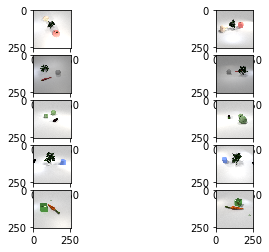

In [20]:
f, axarr = plt.subplots(5,2)
for row in range(5):
    axarr[row,0].imshow(feed_dict_q['images'][row].permute(1,2,0))
    axarr[row,1].imshow(feed_dict_k['images'][row].permute(1,2,0))

In [21]:
feed_dict_q['images'].shape, feed_dict_q['objects'].shape, feed_dict_q['objects_boxes'].shape

(torch.Size([5, 3, 256, 256]), torch.Size([5]), torch.Size([15, 4]))

In [22]:
feed_dict_q['objects']

tensor([3, 3, 3, 3, 3])

In [23]:
feed_dict_q['objects_boxes'].shape

torch.Size([15, 4])

In [24]:
metadata['pix_T_cams_raw'].shape

torch.Size([5, 2, 4, 4])

In [25]:
metadata['camR_T_origin_raw'].shape

torch.Size([5, 2, 4, 4])

In [26]:
metadata['origin_T_camXs_raw'].shape

torch.Size([5, 2, 4, 4])

In [27]:
feed_dict_q['view'].shape

torch.Size([5, 7])